## Unsupervised Clustering

As a group, we will be implementing an unsupervised clustering model using the K-mean algorithm. We are seeking to differentiate AI-related jobs postings from non-AI ones. AI-related job postings will be defined by AI-related keywords. The results will serve to tell us how how certain features separate AI-related job postings from non-AI. 

In [3]:
from pyspark.sql.functions import col, when, lower
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [5]:
from pyspark.sql import SparkSession
## Load the Lightcast Job Posting Data
spark = SparkSession.builder \
.appName("AI_vs_NonAI_JobPostings") \
.config("spark.driver.memory", "4g") \
.getOrCreate()


df = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("./data/lightcast_job_postings.csv")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/04 20:13:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# Need to use KMeans clustering using NAICS job classification as a reference label. I will Compare job title, salary, and industry between AI and non-AI roles.
# The Unnecessary Columns: ID, URL, ACTIVE_URLS, DUPLICATES, LAST_UPDATED_TIMESTAMP, NAICS2, NAICS3, NAICS4, NAICS5, NAICS6, SOC_2, SOC_3, SOC_5. With the removal of older NAICS and SOC codes, our dataset now retains only the most current classification columns: NAICS_2022_6 for industry. I will need to use encoder and pipelines to help.



# Drop unnecessary columns
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
df = df.drop(*columns_to_drop)

# Filter rows with non-null salary and classification columns
df = df.filter(
    (col("SALARY_FROM").isNotNull()) &
    (col("SALARY_TO").isNotNull()) &
    (col("TITLE_RAW").isNotNull()) &
    (col("NAICS_2022_6").isNotNull()) &
    (col("MIN_YEARS_EXPERIENCE").isNotNull()) &
    (col("MAX_YEARS_EXPERIENCE").isNotNull())
)

# Convert salary columns to numeric
df = df.withColumn("SALARY_FROM", col("SALARY_FROM").cast(DoubleType()))
df = df.withColumn("SALARY_TO", col("SALARY_TO").cast(DoubleType()))

# Create average salary column
df = df.withColumn("AVG_SALARY", (col("SALARY_FROM") + col("SALARY_TO")) / 2)

# Convert experience columns and create average experience column
df = df.withColumn("MIN_YEARS_EXPERIENCE", col("MIN_YEARS_EXPERIENCE").cast(DoubleType()))
df = df.withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast(DoubleType()))
df = df.withColumn("AVG_YEARS_EXPERIENCE", (col("MIN_YEARS_EXPERIENCE") + col("MAX_YEARS_EXPERIENCE")) / 2)

# Remove rows with null values in critical columns
df = df.dropna(subset=['AVG_SALARY', 'TITLE_RAW', 'NAICS_2022_6', 'AVG_YEARS_EXPERIENCE'])

# Lowercase the TITLE_RAW column for keyword matching
df = df.withColumn("TITLE_LOWER", lower(col("TITLE_RAW")))

# List of AI keywords
ai_keywords = [
    "ai", "artificial intelligence", "machine learning", "deep learning",
    "neural network", "nlp", "computer vision", "chatgpt", "gpt-3", "gpt-4",
    "llm", "large language model"
]

# Build condition for presence of AI keywords
ai_condition = None
for keyword in ai_keywords:
    condition = col("TITLE_LOWER").contains(keyword)
    if ai_condition is None:
        ai_condition = condition
    else:
        ai_condition = ai_condition | condition

# Create binary column IS_AI_ROLE
df = df.withColumn("IS_AI_ROLE", when(ai_condition, 1).otherwise(0))



















































In [7]:
# Define pipeline stages
title_indexer = StringIndexer(inputCol="TITLE_RAW", outputCol="TITLE_ENCODED", handleInvalid="keep")
naics_indexer = StringIndexer(inputCol="NAICS_2022_6", outputCol="NAICS_ENCODED", handleInvalid="keep")
assembler = VectorAssembler(
    inputCols=["TITLE_ENCODED", "NAICS_ENCODED", "AVG_SALARY", "AVG_YEARS_EXPERIENCE"], 
    outputCol="features"
)
kmeans = KMeans(featuresCol="features", predictionCol="CLUSTER", k=2, seed=42)

# Create pipeline
pipeline = Pipeline(stages=[title_indexer, naics_indexer, assembler, kmeans])

# Fit pipeline
model = pipeline.fit(df)




25/10/04 20:14:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Features and Silhouette Score
We will be using the following features for our clustering model:

- Average Salary, expected to capture pay differences
- Job Title (Encoded), expected to capture role differences
- NAICS Code (Encoded), expected to separate jobs by sectors
- Average Years of Experience, expected to capture experience level differences

Grouping these features in a cluster of 2, we found a silhouette score of approximately 0.695, indicating a good clustering structure. However, since the score is not closer to 1 than expected, reflecting the complexity between AI and non-AI job postings.


In [8]:
# Transform data to get cluster predictions
predictions = model.transform(df)

# Evaluate clustering
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="CLUSTER", metricName="silhouette")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score = {silhouette}")

# Show cluster counts grouped by AI role
predictions.groupBy("IS_AI_ROLE", "CLUSTER").count().show()

Silhouette score = 0.6952339062845586


+----------+-------+-----+
|IS_AI_ROLE|CLUSTER|count|
+----------+-------+-----+
|         1|      0|   47|
|         1|      1|   19|
|         0|      0| 2195|
|         0|      1| 1669|
+----------+-------+-----+



# Pairwise Plots

Below are a series of pairwise plots showing the relationships between the features used in the clustering model, consisting of Average Salary, Job Title (Encoded), NAICS Code (Encoded), and Average Years of Experience. The plots seek to visualize how these features interact and potentially separate AI-related job postings from non-AI ones. From the plots, a clear relationship is not visible between the features due to the lower number of AI-related job postings in the dataset. 

It would be unusual to see any AI jobs since AI jobs are not common in the hiring process. The few present in the visualizations are likely the ones that require higher technical skills in the ML domain. To further study our prompt, other processes will need to be performed.

In [14]:
import hvplot.pandas
import panel as pn
pn.extension()

# Sample 5% of the data to reduce size for plotting
sample_pdf = predictions.select("AVG_SALARY", "TITLE_ENCODED", "NAICS_ENCODED", "AVG_YEARS_EXPERIENCE", "IS_AI_ROLE") \
    .sample(fraction=0.05, seed=42) \
    .toPandas()

# Map IS_AI_ROLE to string labels for coloring
sample_pdf['Role'] = sample_pdf['IS_AI_ROLE'].map({0: 'Non-AI', 1: 'AI'})

# Columns to plot
cols = ["AVG_SALARY", "TITLE_ENCODED", "NAICS_ENCODED", "AVG_YEARS_EXPERIENCE"]

plots = []
for x in cols:
    for y in cols:
        if x != y:
            plot = sample_pdf.hvplot.scatter(
                x=x, y=y, by='Role', width=450, height=250, alpha=0.6, title=f"{y} vs {x}"
            )
            plots.append(plot)

# Arrange plots in a grid with 2 columns
pn.GridBox(*plots, ncols=2)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4aea27ee-1f91-4329-93c8-6b918f9473ac': {'version…

# PCA 2D Visualization Excluding Salary

Generating a 2D PCA plot excluding salary to visualize the clustering of AI-related and non-AI jobs based served as a useful alternative to the previous pairwise plots. The following PCA plots consist of PC1 vs PC2, PC1 vs PC3, and PC2 vs PC3. 

The PC1 vs PC2 plots shows some separation between clusters along PC1, but a lot of overlap along PC2. The PC1 vs PC3 plot demonstrates a clearer separation between the clusters, with cluster groups more distinctly divided along PC3. The PC2 vs PC3 presents moderate cluster separation, with the appearance of vertical banding along PC2.

The results of the PCA plots indicate the there are now two visually distinct clusters, which is an improvement from the previous pairwise plots. However, there is still confusion regarding which features strongly divide AI-related job postings from non-AI ones.

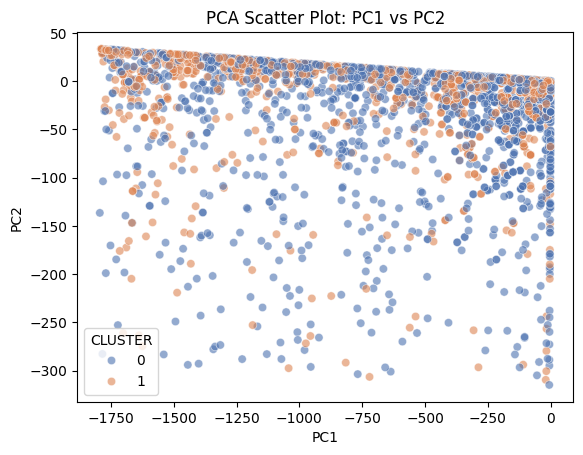

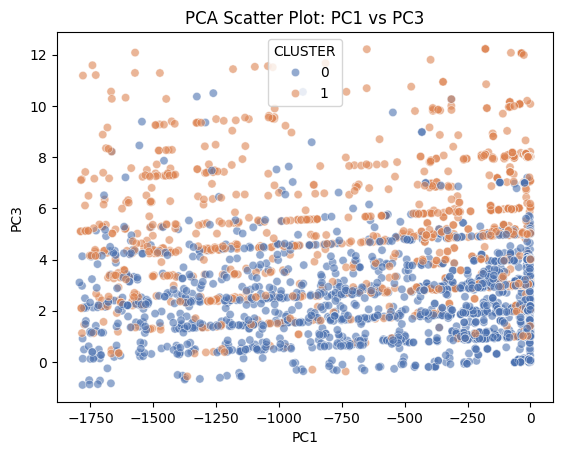

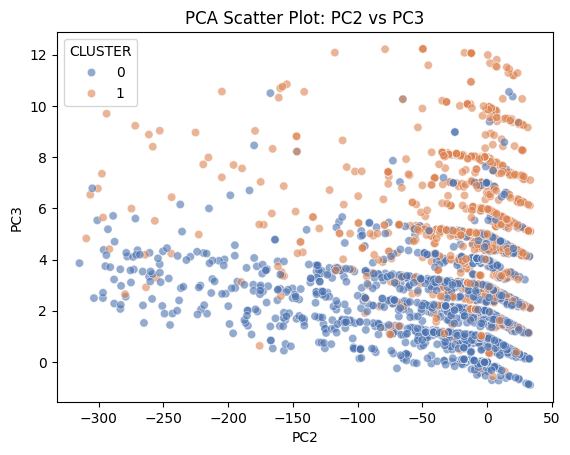

In [10]:
from pyspark.ml.feature import VectorAssembler, PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Assemble features excluding AVG_SALARY
assembler_no_salary = VectorAssembler(
    inputCols=["TITLE_ENCODED", "NAICS_ENCODED", "AVG_YEARS_EXPERIENCE"],
    outputCol="features_no_salary"
)

df_features = assembler_no_salary.transform(predictions)

# Step 2: Fit PCA with k=3 (max components for 3 features)
pca = PCA(k=3, inputCol="features_no_salary", outputCol="pcaFeatures")
pca_model = pca.fit(df_features)
pca_result = pca_model.transform(df_features)

# Step 3: Convert to Pandas for plotting
pdf_pca = pca_result.select("pcaFeatures", "CLUSTER").toPandas()

# Extract PCA components to separate columns
pdf_pca["PC1"] = pdf_pca["pcaFeatures"].apply(lambda x: x[0])
pdf_pca["PC2"] = pdf_pca["pcaFeatures"].apply(lambda x: x[1])
pdf_pca["PC3"] = pdf_pca["pcaFeatures"].apply(lambda x: x[2])

# Step 4: Plotting function
def plot_pcs(x, y):
    sns.scatterplot(data=pdf_pca, x=x, y=y, hue="CLUSTER", palette="deep", alpha=0.6)
    plt.title(f"PCA Scatter Plot: {x} vs {y}")
    plt.show()

# Plot PC1 vs PC2
plot_pcs("PC1", "PC2")

# Plot PC1 vs PC3
plot_pcs("PC1", "PC3")

# Plot PC2 vs PC3
plot_pcs("PC2", "PC3")

In [11]:
# pca loadings from the data, and it will show which variable contributes to which component
from pyspark.ml.feature import VectorAssembler, PCA
import pandas as pd

# Replace with your actual feature columns
features_list = ["TITLE_ENCODED", "NAICS_ENCODED", "AVG_YEARS_EXPERIENCE"]

# Step 1: Assemble features into a vector column
assembler = VectorAssembler(inputCols=features_list, outputCol="features_no_salary")
df_features = assembler.transform(predictions)

# Step 2: Fit PCA with k=3 components
no_of_components = 3
pca = PCA(k=no_of_components, inputCol="features_no_salary", outputCol="pcaFeatures")
pca_model = pca.fit(df_features)

In [12]:
# Step 3: Transform data to get PCA features (optional, for inspection)
pca_result = pca_model.transform(df_features).select("pcaFeatures")
pca_result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-434.0185456930057,3.101580098050471,1.811683036249945]    |
|[-109.50262160715904,-293.9577773405844,9.695411396258624]  |
|[-1247.9888950647032,12.273883719132867,1.4386012760463722] |
|[-1211.4252314690048,-11.393578486713505,4.592921677564275] |
|[-272.13951568117056,-4.922697936425175,0.9225236282489951] |
|[-18.239980098450495,-12.650208761515005,2.067690571197463] |
|[-8.130267506633855,-6.831820831431559,3.0372642950180575]  |
|[-11.999872656956287,0.2532177690156582,4.993889964575481]  |
|[-8.130267506633855,-6.831820831431559,3.0372642950180575]  |
|[-8.130267506633855,-6.831820831431559,3.0372642950180575]  |
|[-0.09398554349908207,-4.987218343635428,2.029487598020609] |
|[-1312.0713641273346,8.473570707703395,2.4359877869086315]  |
|[-360.35583609961265,-69.27085401271545,4.268509493753

# Loading the PCA Data

Loading the data set, PC1 is entirely dominated by TITLE_ENCODED, with a coefficient of 0.999. This means the differences in job titles are the main factor separating the clusters. The second largest variance, PC2, is dominated by NAICS_ENCODED with a coefficient of 0.998, indicating that the industry sector is the next most important factor. PC3 is dominated by AVG_YEARS_EXPERIENCE with a coefficient of 0.999, suggesting that experience level is also a significant factor in distinguishing between job postings, which could lead to differences in salary.



# Differences Between AI and Non-AI Job Postings Using K-Means Clustering

Using K-means clustering, we identified two clusters in our dataset through a series of processes including selecting features, calculating a silhouette score, and visualizing the data using PCA 2D plots. Although this is an unsupervised learning method, the clusters likely correspond to AI-related and non-AI jobs postings based on the features used. Clusters are primarily separated by job titles, a strong indicator of whether a job is AI-related. Industry classification and experience level also play a role in distinguishing between the two types of job postings. The process, while not definitive, provides insights into the characteristics that differentiate AI-related jobs postings from non-AI ones in the dataset. 

In [13]:
# Step 4: Extract PCA loadings matrix
loadings_matrix = pca_model.pc.toArray()

# Step 5: Create Pandas DataFrame for loadings
loading_scores = pd.DataFrame(loadings_matrix, columns=[f"PCA{i+1}" for i in range(no_of_components)])
loading_scores["Variable"] = features_list

# Reorder columns for readability
loading_scores = loading_scores[["Variable"] + [f"PCA{i+1}" for i in range(no_of_components)]]

# Step 6: Print loadings
print(loading_scores)

               Variable      PCA1      PCA2      PCA3
0         TITLE_ENCODED -0.999826  0.018638 -0.000502
1         NAICS_ENCODED -0.018640 -0.999809  0.005905
2  AVG_YEARS_EXPERIENCE -0.000392  0.005913  0.999982


## Random Forest Classification part 1 - selecting ai vs non ai and observation

In [ ]:
import pandas as pd

df = pd.read_csv("lightcast_job_postings.csv", low_memory=False)

#TITLE_CLEAN is a string
df["TITLE_CLEAN"] = df["TITLE_CLEAN"].astype(str)

#defining AI-related keywords
ai_keywords = [
    "AI", "Artificial Intelligence", "Machine Learning", "Deep Learning",
    "Neural", "Data Scientist", "Computer Vision", "NLP", "Natural Language",
    "LLM", "Chatbot", "Generative", "Data Engineer", "Software", "Data"
]

#creatung AI_JOB column: 1 = AI job, 0 = Non-AI job
df["AI_JOB"] = df["TITLE_CLEAN"].apply(
    lambda x: 1 if any(keyword.lower() in x.lower() for keyword in ai_keywords) else 0
)

#shows how many AI vs Non-AI jobs
print(df["AI_JOB"].value_counts())

#
print(df.groupby("AI_JOB")["SALARY"].describe())

df.groupby("AI_JOB")["NAICS_2022_6_NAME"].value_counts().head(10)

In this dataset of 72,498 job postings, 30,197 positions (≈42%) were classified as AI-related, while 42,301 (≈58%) were non-AI. Non-AI roles have a slightly higher average salary ($128K vs. $105K for AI roles) and show substantial variation, with salaries ranging from $15K to $500K. Non-AI jobs are concentrated in consulting, administrative, and computer-related services, whereas AI roles are more dispersed across technical and data-focused industries. These patterns highlight differences in compensation and industry focus between AI and non-AI careers.



## Random Forest Classification part 2 - features used to determine to predict ai vs non ai job  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

features = ["SOFTWARE_SKILLS", "SPECIALIZED_SKILLS", "MIN_EDULEVELS", "MAX_EDULEVELS", "NAICS_2022_6_NAME", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "SOC_5_NAME" ]
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df["AI_JOB"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Using a Random Forest classifier to predict AI-related jobs based on skills, education, experience, industry, and job title, the model achieved an overall accuracy of 63%. The classifier performs better at identifying non-AI jobs (recall 0.80) than AI jobs (recall 0.40), indicating it is more likely to misclassify AI roles. Precision and F1-scores reflect this imbalance, with non-AI roles having higher scores than AI roles. These results suggest that while features like education, experience, and industry provide some predictive power, distinguishing AI from non-AI positions remains challenging with the current feature set.

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

The Logistic Regression Model has similar results to the RFC because the features are not too strong, leading to such outcomes.


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Features: AI_JOB, MIN_YEARS_EXPERIENCE, MAX_YEARS_EXPERIENCE, MIN_EDULEVELS, MAX_EDULEVELS
features = ["AI_JOB", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "MIN_EDULEVELS", "MAX_EDULEVELS"]
X_salary = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y_salary = pd.to_numeric(df["SALARY"], errors='coerce').fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_salary, y_salary, test_size=0.2, random_state=42
)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("RMSE:", rmse)

# Coefficients
coefficients = pd.DataFrame({
    "Feature": X_salary.columns,
    "Coefficient": lr.coef_
})
print("\nCoefficients:")
print(coefficients)

print("\nIntercept (base salary):", lr.intercept_)

The Linear regression model examining salary differences between AI and Non-AI roles shows that experience and education are the main drivers of salary, while being an AI role has minimal direct effect. Specifically, each additional year of minimum experience increases salary by ~$3,579, and higher maximum education increases it by ~$3,507, whereas the AI_JOB coefficient is slightly negative (-$889). The model explains about 7.9% of salary variation (R² = 0.079), with an average prediction error of $63,043 (RMSE). The intercept (~$38,466) represents the predicted base salary for a non-AI job with zero experience and base education levels. Overall, salary differences are largely influenced by experience and education rather than AI-role designation.